In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [2]:
def interlocking_function(x_interface_coordinate):
    #x_mhd = 0.0にする
    F = 0.5 * (1.0 + np.cos(np.pi * (x_interface_coordinate - 0.0) / (x_interface_coordinate[-1] - 0.0)))
    #F = 0.5 * (1.0 + np.tanh((x_interface_coordinate[10] - x_interface_coordinate) / 5.0))
    return F


def get_interface_quantity(x_interface_coordinate, q_mhd, q_pic):
    F = interlocking_function(x_interface_coordinate)
    q_interface = F * q_mhd + (1.0 - F) * q_pic
    return q_interface


def send_MHD_to_PICinterface_B(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U, B_pic
    ):

    Bx_mhd = U[4, :]
    By_mhd = U[5, :]
    Bz_mhd = U[6, :]

    #PICグリッドに合わせる
    Bx_mhd = Bx_mhd #CT法は1次元では使っていないのでこのまま
    By_mhd = 0.5 * (By_mhd + np.roll(By_mhd, -1, axis=0))
    Bz_mhd = 0.5 * (Bz_mhd + np.roll(Bz_mhd, -1, axis=0))

    Bx_mhd = Bx_mhd[index_interface_mhd_start:index_interface_mhd_end]
    By_mhd = By_mhd[index_interface_mhd_start:index_interface_mhd_end - 1]
    Bz_mhd = Bz_mhd[index_interface_mhd_start:index_interface_mhd_end - 1]

    x_interface_coordinate = np.arange(0, index_interface_pic_end - index_interface_pic_start, 1)
    x_interface_coordinate_half = np.arange(index_interface_pic_start + 0.5, 
                                            index_interface_pic_end - index_interface_pic_start - 0.5, 
                                            1)
    
    B_pic[0, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity(
        x_interface_coordinate, Bx_mhd, 
        B_pic[0, index_interface_pic_start:index_interface_pic_end]
    )
    B_pic[1, index_interface_pic_start:index_interface_pic_end - 1] = get_interface_quantity(
        x_interface_coordinate_half, By_mhd, 
        B_pic[1, index_interface_pic_start:index_interface_pic_end - 1]
    )
    B_pic[2, index_interface_pic_start:index_interface_pic_end - 1] = get_interface_quantity(
        x_interface_coordinate_half, Bz_mhd, 
        B_pic[2, index_interface_pic_start:index_interface_pic_end - 1]
    )
    
    return B_pic



In [7]:
lambda_mhd = lambda_pic = 20.0
kx_mhd = 2.0 * np.pi / lambda_mhd
kx_pic = 2.0 * np.pi / lambda_pic

In [52]:
c = 0.5
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 100 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.2*c)**2
Ti_pic = Te_pic / t_r
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)

dx_pic = debye_length
nx_pic = 100
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 1.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[2, :] = B0_pic * np.sin(kx_pic * x_coordinate_pic)

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
x_start_ion = np.linspace(x_min_pic, x_max_pic, n_ion)
x_start_electron = np.linspace(x_min_pic, x_max_pic, n_electron)

x_pic_ion[0, :] = x_start_ion
x_pic_electron[0, :] = x_start_electron
v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion, random_state=30))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion, random_state=40))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion, random_state=50))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron, random_state=60))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron, random_state=70))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron, random_state=80))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")

total number of particles is 20000.
Box size is 100


In [53]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
Cf_mhd = np.sqrt((B0_mhd**2 + 2.0 * p0_mhd) / rho0_mhd)
dx_mhd = dx_pic

nx_mhd = 100
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.2
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

lambda_mhd = 20.0
kx_mhd = 2.0 * np.pi / lambda_mhd
U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd 
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = 0.0
Bz_init = B0_mhd * np.sin(kx_mhd * (x_coordinate_mhd - 0.5 * dx_mhd))
p_init = p0_mhd
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F1 = np.zeros(U1.shape)
F1_bar = np.zeros(F1.shape)
G1 = np.zeros(U1.shape)
G1_bar = np.zeros(G1.shape)

U2 = U1.copy()
F2 = F1.copy()
F2_bar = F1_bar.copy()
G2 = G1.copy()
G2_bar2 = G1_bar.copy()

print(f"U size is {U1.shape}")

U size is (8, 100)


In [54]:
index_interface_mhd_start = nx_mhd - int(lambda_mhd)
index_interface_mhd_end = nx_mhd
index_interface_pic_start = 0
index_interface_pic_end = int(lambda_pic)

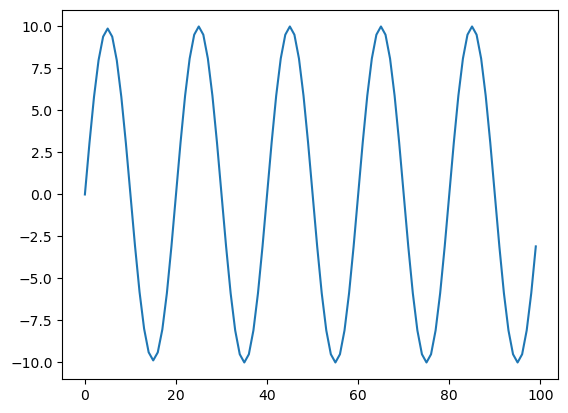

In [55]:
for i in range(100):
    B_pic = send_MHD_to_PICinterface_B(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1, B_pic
    )

plt.plot(B_pic[2, :])
#plt.plot(U1[6, :])